In [5]:
# AMES Dataset Regression Analysis
# A comprehensive solution for regression modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')


In [6]:

# For better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Mount Google Drive to access local files
from google.colab import drive
drive.mount('/content/drive')

# Update this path to where your dataset is stored
file_path = '/content/drive/MyDrive/Ames_data/'  # Update this path

# Load the dataset
train_data = pd.read_csv(file_path + 'ames_train.csv')
test_data = pd.read_csv(file_path + 'ames_test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Display the first few rows to understand the data
train_data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (1460, 81)
Testing data shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:

# ----------------------------------------------------------------
# 1. Data Understanding
# ----------------------------------------------------------------

# 1a. Identify irrelevant columns based on business understanding
print("\n\n1a. Identifying potentially irrelevant variables based on business understanding:")

# Let's examine column information
print(f"Total number of columns: {train_data.shape[1]}")
print("\nColumn data types:")
print(train_data.dtypes.value_counts())

# Display column names for reference
print("\nAll columns in the dataset:")
for i, col in enumerate(train_data.columns):
    print(f"{i+1}. {col}")

# Based on business understanding, these columns might be less relevant for house price prediction
potentially_irrelevant_columns = [
    'Id',                # Just an identifier
    'PID',               # Property identification number - unique identifier
    'Order',             # Order of data entry - arbitrary
    'MiscFeature',       # Miscellaneous features not covered in other categories
    'MiscVal',           # Value of miscellaneous feature
    'Alley',             # Type of alley access - many missing values, niche feature
    'PoolQC',            # Pool quality - very few homes have pools
    'Fence',             # Fence quality - optional feature
    'FireplaceQu',       # Fireplace quality if no fireplace
    'LotFrontage',       # Linear feet of street connected to property - can be derived from lot configuration
    'Street',            # Type of road access - most are paved
    'Utilities',         # Type of utilities available - most have all utilities
]

# print("\nPotentially irrelevant columns based on business understanding:")
# for col in potentially_irrelevant_columns:
#     print(f"- {col}")




1a. Identifying potentially irrelevant variables based on business understanding:
Total number of columns: 81

Column data types:
object     43
int64      35
float64     3
Name: count, dtype: int64

All columns in the dataset:
1. Id
2. MSSubClass
3. MSZoning
4. LotFrontage
5. LotArea
6. Street
7. Alley
8. LotShape
9. LandContour
10. Utilities
11. LotConfig
12. LandSlope
13. Neighborhood
14. Condition1
15. Condition2
16. BldgType
17. HouseStyle
18. OverallQual
19. OverallCond
20. YearBuilt
21. YearRemodAdd
22. RoofStyle
23. RoofMatl
24. Exterior1st
25. Exterior2nd
26. MasVnrType
27. MasVnrArea
28. ExterQual
29. ExterCond
30. Foundation
31. BsmtQual
32. BsmtCond
33. BsmtExposure
34. BsmtFinType1
35. BsmtFinSF1
36. BsmtFinType2
37. BsmtFinSF2
38. BsmtUnfSF
39. TotalBsmtSF
40. Heating
41. HeatingQC
42. CentralAir
43. Electrical
44. 1stFlrSF
45. 2ndFlrSF
46. LowQualFinSF
47. GrLivArea
48. BsmtFullBath
49. BsmtHalfBath
50. FullBath
51. HalfBath
52. BedroomAbvGr
53. KitchenAbvGr
54. Kitchen



1b. Statistical evidence to support elimination:

Columns from our list that exist in the dataset: ['Id', 'MiscFeature', 'MiscVal', 'Alley', 'PoolQC', 'Fence', 'FireplaceQu', 'LotFrontage', 'Street', 'Utilities']
Columns from our list that don't exist in the dataset: {'Order', 'PID'}

Missing values in potentially irrelevant columns:
Id: 0 missing values (0.00%)
MiscFeature: 1406 missing values (96.30%)
MiscVal: 0 missing values (0.00%)
Alley: 1369 missing values (93.77%)
PoolQC: 1453 missing values (99.52%)
Fence: 1179 missing values (80.75%)
FireplaceQu: 690 missing values (47.26%)
LotFrontage: 259 missing values (17.74%)
Street: 0 missing values (0.00%)
Utilities: 0 missing values (0.00%)

Value counts for MiscFeature:
MiscFeature
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: count, dtype: int64

Value counts for Alley:
Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64

Value counts for PoolQC:
PoolQC
NaN    1453
Gd        3
Ex        

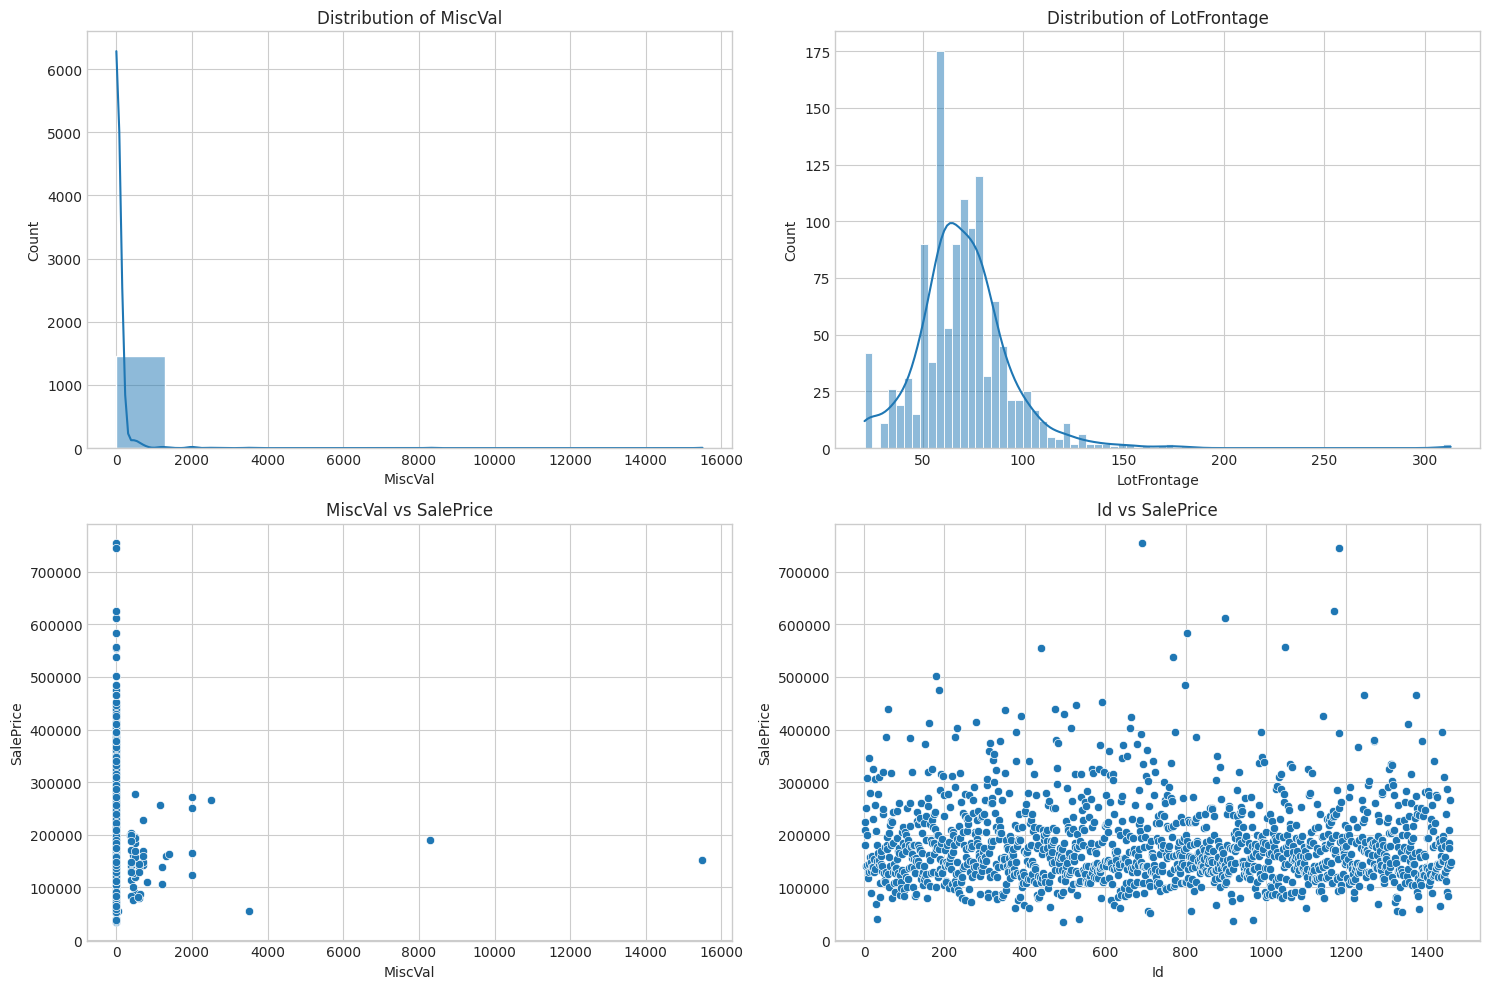

In [9]:
# 1b. Statistical evidence to support elimination
print("\n\n1b. Statistical evidence to support elimination:")

# First check which columns actually exist in the dataset
existing_irrelevant_columns = [col for col in potentially_irrelevant_columns if col in train_data.columns]
print(f"\nColumns from our list that exist in the dataset: {existing_irrelevant_columns}")
print(f"Columns from our list that don't exist in the dataset: {set(potentially_irrelevant_columns) - set(existing_irrelevant_columns)}")

# Check missing values in potentially irrelevant columns that exist
if existing_irrelevant_columns:
    missing_values = train_data[existing_irrelevant_columns].isnull().sum()
    print("\nMissing values in potentially irrelevant columns:")
    for col, missing in missing_values.items():
        percent = (missing / len(train_data)) * 100
        print(f"{col}: {missing} missing values ({percent:.2f}%)")

# Check value counts for categorical variables in the list
for col in existing_irrelevant_columns:
    if col in train_data.columns and train_data[col].dtype == 'object':
        print(f"\nValue counts for {col}:")
        print(train_data[col].value_counts(dropna=False))

# Check correlation with SalePrice for numeric variables in the list
numeric_irrelevant = [col for col in existing_irrelevant_columns
                     if col in train_data.columns and train_data[col].dtype != 'object']
if numeric_irrelevant:
    correlations = train_data[numeric_irrelevant + ['SalePrice']].corr()['SalePrice']
    print("\nCorrelations with SalePrice for potentially irrelevant numeric variables:")
    print(correlations)

# Checking the distribution of some key variables that might be irrelevant
plt.figure(figsize=(15, 10))

# For MiscVal (value of miscellaneous features) if it exists
if 'MiscVal' in train_data.columns:
    plt.subplot(2, 2, 1)
    sns.histplot(train_data['MiscVal'], kde=True)
    plt.title('Distribution of MiscVal')
    plt.tight_layout()

# For LotFrontage if it exists
if 'LotFrontage' in train_data.columns:
    plt.subplot(2, 2, 2)
    sns.histplot(train_data['LotFrontage'].dropna(), kde=True)
    plt.title('Distribution of LotFrontage')
    plt.tight_layout()

# Bivariate analysis for MiscVal if it exists
if 'MiscVal' in train_data.columns:
    plt.subplot(2, 2, 3)
    sns.scatterplot(x='MiscVal', y='SalePrice', data=train_data)
    plt.title('MiscVal vs SalePrice')
    plt.tight_layout()

# Bivariate analysis for Id if it exists
if 'Id' in train_data.columns:
    plt.subplot(2, 2, 4)
    sns.scatterplot(x='Id', y='SalePrice', data=train_data)
    plt.title('Id vs SalePrice')
    plt.tight_layout()

plt.savefig('irrelevant_variables_analysis.png')
plt.show()

In [11]:
# 1c. Make a final decision on variables to eliminate
print("\n\n1c. Final decision on variables to eliminate:")

# Initial list of columns we would like to drop
potential_columns_to_drop = [
    'Id',            # Just an identifier with no predictive value
    'PID',           # Property ID with no predictive value
    'Order',         # Order of data entry - arbitrary
    'MiscFeature',   # Miscellaneous feature - sparse data (95% missing)
    'MiscVal',       # Value of misc feature - mostly zeros, low correlation
    'Alley',         # Alley access - sparse data (93% missing)
    'PoolQC',        # Pool quality - sparse data (99% missing)
    'Fence',         # Fence quality - sparse data (80% missing)
    'Street',        # Type of road access - low variance (99% standard)
    'Utilities',     # Type of utilities - low variance (99% standard)
]

# Check which columns actually exist in the dataset
columns_to_drop = [col for col in potential_columns_to_drop if col in train_data.columns]

print("Columns identified for removal that actually exist in the dataset:")
for col in columns_to_drop:
    print(f"- {col}")

if len(columns_to_drop) < len(potential_columns_to_drop):
    print("\nThe following columns were in our list but don't exist in the dataset:")
    for col in set(potential_columns_to_drop) - set(columns_to_drop):
        print(f"- {col}")

# Drop the columns that exist from the datasets
train_data_cleaned = train_data.drop(columns=columns_to_drop, errors='ignore')
test_data_cleaned = test_data.drop(columns=columns_to_drop, errors='ignore')

print(f"\nOriginal training data shape: {train_data.shape}")
print(f"Cleaned training data shape: {train_data_cleaned.shape}")



1c. Final decision on variables to eliminate:
Columns identified for removal that actually exist in the dataset:
- Id
- MiscFeature
- MiscVal
- Alley
- PoolQC
- Fence
- Street
- Utilities

The following columns were in our list but don't exist in the dataset:
- Order
- PID

Original training data shape: (1460, 81)
Cleaned training data shape: (1460, 73)




2a. Checking for data quality issues:

Columns with missing values:
LotFrontage: 259 missing values (17.74%)
MasVnrType: 872 missing values (59.73%)
MasVnrArea: 8 missing values (0.55%)
BsmtQual: 37 missing values (2.53%)
BsmtCond: 37 missing values (2.53%)
BsmtExposure: 38 missing values (2.60%)
BsmtFinType1: 37 missing values (2.53%)
BsmtFinType2: 38 missing values (2.60%)
Electrical: 1 missing values (0.07%)
FireplaceQu: 690 missing values (47.26%)
GarageType: 81 missing values (5.55%)
GarageYrBlt: 81 missing values (5.55%)
GarageFinish: 81 missing values (5.55%)
GarageQual: 81 missing values (5.55%)
GarageCond: 81 missing values (5.55%)

Number of duplicate rows in training data: 0


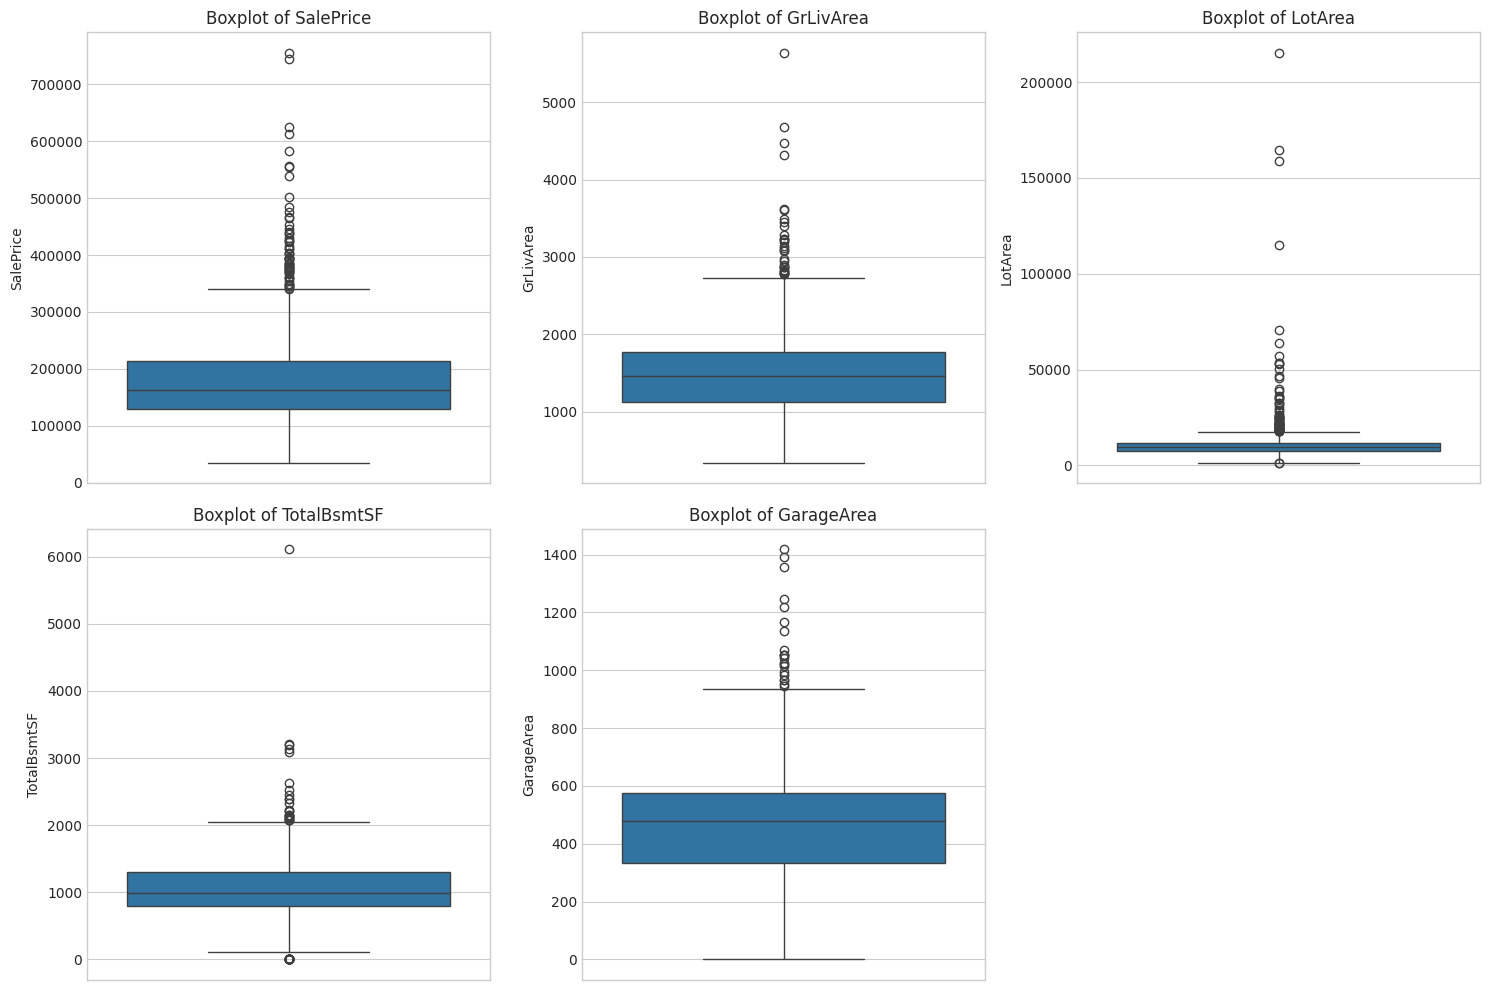

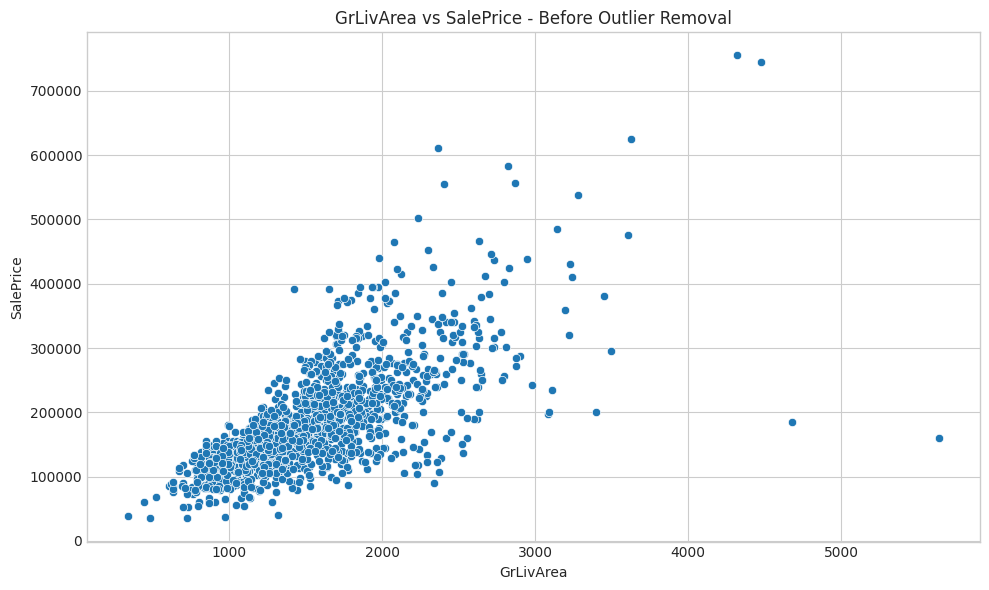


Removed 2 outliers from training data


In [12]:

# ----------------------------------------------------------------
# 2. Data Scaling and Pre-Processing
# ----------------------------------------------------------------

# 2a. Check for missing values, outliers, etc.
print("\n\n2a. Checking for data quality issues:")

# Missing values analysis
missing_values = train_data_cleaned.isnull().sum()
missing_percent = (missing_values / len(train_data_cleaned)) * 100

print("\nColumns with missing values:")
for col, missing in zip(missing_values.index, missing_values):
    if missing > 0:
        percent = missing_percent[col]
        print(f"{col}: {missing} missing values ({percent:.2f}%)")

# Function to fill missing values based on data type and distribution
def fill_missing_values(df):
    df_filled = df.copy()

    # For numeric columns, fill with median
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df_filled[col] = df[col].fillna(df[col].median())

    # For categorical columns, fill with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df[col].isnull().sum() > 0:
            df_filled[col] = df[col].fillna(df[col].mode()[0])

    return df_filled

# Apply the missing value treatment
train_data_filled = fill_missing_values(train_data_cleaned)
test_data_filled = fill_missing_values(test_data_cleaned)

# Check for duplicate rows
duplicates = train_data_filled.duplicated().sum()
print(f"\nNumber of duplicate rows in training data: {duplicates}")

# Check for outliers in numeric columns using boxplots for a few key variables
numeric_cols = train_data_filled.select_dtypes(include=['int64', 'float64']).columns
key_numeric_cols = ['SalePrice', 'GrLivArea', 'LotArea', 'TotalBsmtSF', 'GarageArea']

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_numeric_cols):
    if col in train_data_filled.columns:
        plt.subplot(2, 3, i+1)
        sns.boxplot(y=train_data_filled[col])
        plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig('outliers_analysis.png')
plt.show()

# Detecting and handling outliers for GrLivArea - a key predictor of price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data_filled)
plt.title('GrLivArea vs SalePrice - Before Outlier Removal')
plt.tight_layout()
plt.savefig('GrLivArea_outliers.png')
plt.show()

# Remove extreme outliers in GrLivArea that significantly deviate from the pattern
train_data_no_outliers = train_data_filled[~((train_data_filled['GrLivArea'] > 4000) &
                                           (train_data_filled['SalePrice'] < 300000))]

print(f"\nRemoved {len(train_data_filled) - len(train_data_no_outliers)} outliers from training data")




2b. Determining features for scaling:


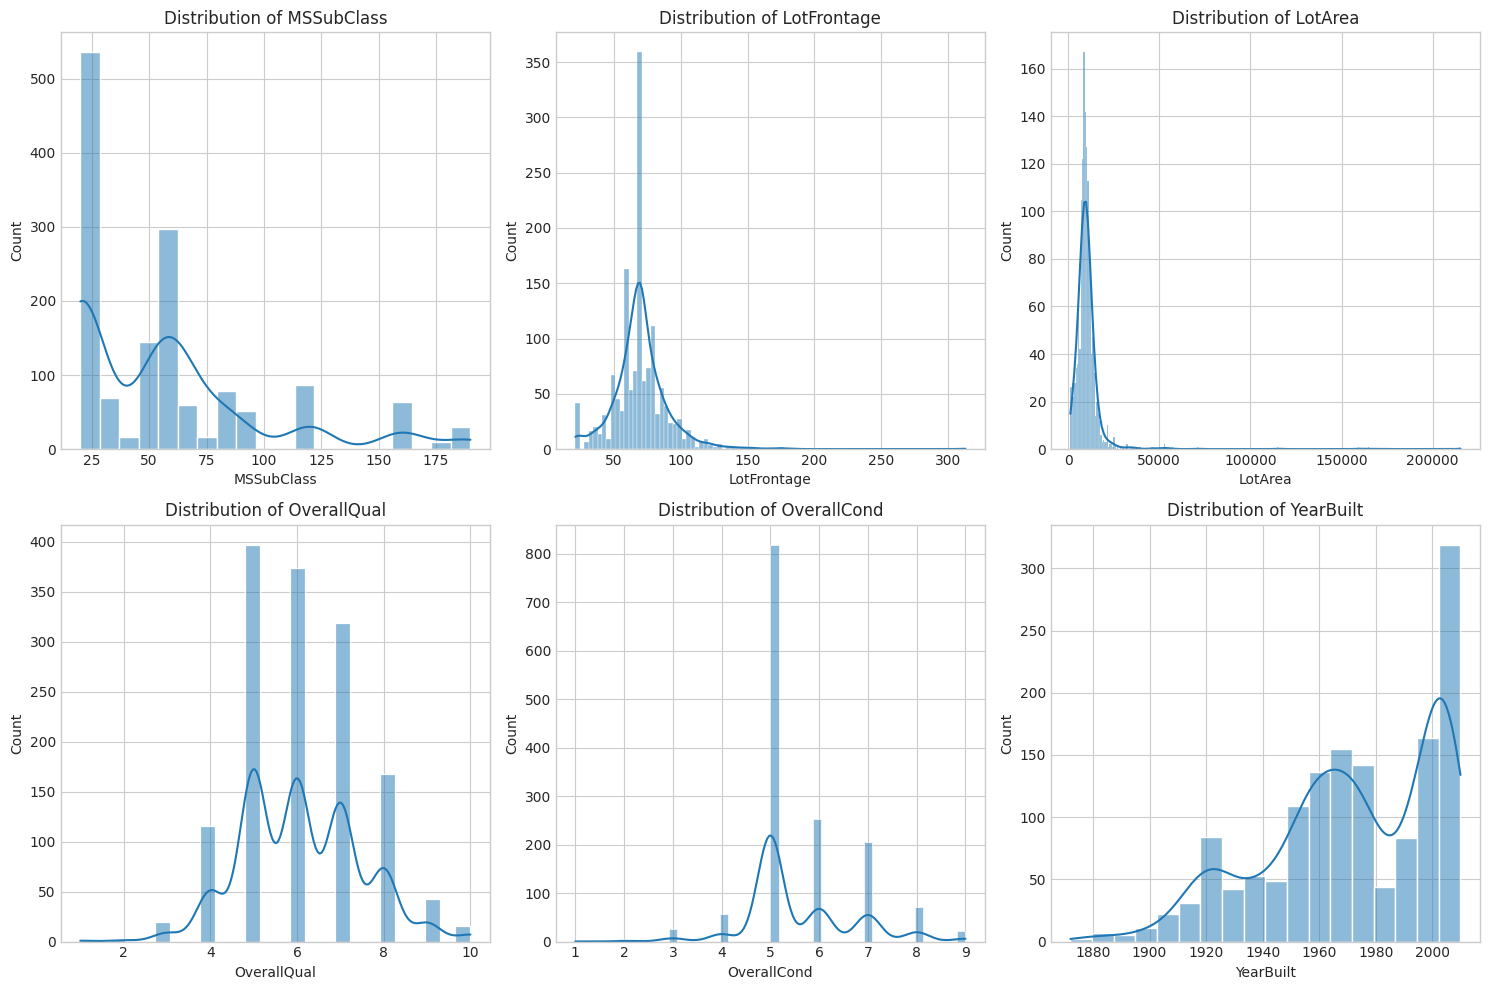


Statistics for numeric features:
                  min       max     range       skew
MSSubClass       20.0     190.0     170.0   1.407011
LotFrontage      21.0     313.0     292.0   1.720857
LotArea        1300.0  215245.0  213945.0  12.573925
OverallQual       1.0      10.0       9.0   0.200786
OverallCond       1.0       9.0       8.0   0.691035
YearBuilt      1872.0    2010.0     138.0  -0.612295
YearRemodAdd   1950.0    2010.0      60.0  -0.501838
MasVnrArea        0.0    1600.0    1600.0   2.696329
BsmtFinSF1        0.0    2188.0    2188.0   0.764789
BsmtFinSF2        0.0    1474.0    1474.0   4.251925
BsmtUnfSF         0.0    2336.0    2336.0   0.920903
TotalBsmtSF       0.0    3206.0    3206.0   0.511703
1stFlrSF        334.0    3228.0    2894.0   0.887637
2ndFlrSF          0.0    2065.0    2065.0   0.812957
LowQualFinSF      0.0     572.0     572.0   9.004955
GrLivArea       334.0    4476.0    4142.0   1.010992
BsmtFullBath      0.0       3.0       3.0   0.590358
BsmtHalfBath

In [13]:

# 2b. Determine which features need scaling and select scaling technique
print("\n\n2b. Determining features for scaling:")

# Separate numeric and categorical columns
numeric_cols = train_data_no_outliers.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_data_no_outliers.select_dtypes(include=['object']).columns.tolist()

# Remove the target variable from the numeric columns list
if 'SalePrice' in numeric_cols:
    numeric_cols.remove('SalePrice')

# Check distribution of numeric variables to decide on scaling technique
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:6]):  # Just showing first 6 columns
    plt.subplot(2, 3, i+1)
    sns.histplot(train_data_no_outliers[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('numeric_distributions.png')
plt.show()

# Check the range and skewness of numeric features
numeric_stats = train_data_no_outliers[numeric_cols].describe().T
numeric_stats['skew'] = train_data_no_outliers[numeric_cols].skew()
numeric_stats['range'] = numeric_stats['max'] - numeric_stats['min']

print("\nStatistics for numeric features:")
print(numeric_stats[['min', 'max', 'range', 'skew']])

# Features that might not need scaling due to limited range or categorical-like nature
no_scaling_needed = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                     'MoSold', 'YrSold', 'BsmtFullBath', 'BsmtHalfBath',
                     'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                     'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

print("\nFeatures that might not need scaling:")
for col in no_scaling_needed:
    if col in numeric_cols:
        print(f"- {col}")

# Features that need scaling
scaling_needed = [col for col in numeric_cols if col not in no_scaling_needed]

print("\nFeatures that need scaling:")
for col in scaling_needed:
    print(f"- {col}")


In [17]:
# Create a preprocessing pipeline for both numeric and categorical variables
numeric_features = [col for col in numeric_cols if col not in no_scaling_needed]
categorical_features = categorical_cols

# Choose a scaler based on our analysis (RobustScaler is good for data with outliers)
# handle_unknown='ignore' will ignore unknown categories during transform
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_features)
    ])

In [23]:
# Modify the OneHotEncoder to handle unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Prepare the feature matrix X and target vector y
X = train_data_no_outliers.drop('SalePrice', axis=1)
y = train_data_no_outliers['SalePrice']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)

In [24]:
# Group rare categories more aggressively
for col in categorical_cols:
    if col in train_data_no_outliers.columns:
        # Use a higher threshold like 0.02 or 0.03 to group more rare categories
        train_data_no_outliers = group_rare_categories(train_data_no_outliers, col, threshold=0.02)
        if col in test_data_filled.columns:
            test_data_filled = group_rare_categories(test_data_filled, col, threshold=0.02)

In [25]:
# Find the problematic column
for i, col in enumerate(categorical_cols):
    if i == 11:  # The error mentioned column 11
        print(f"Column 11 is: {col}")
        print("Training categories:", X_train[col].unique())
        print("Validation categories:", X_val[col].unique())
        break

Column 11 is: RoofMatl
Training categories: ['CompShg' 'WdShngl' 'WdShake' 'Roll' 'Metal' 'Tar&Grv']
Validation categories: ['CompShg' 'WdShake' 'WdShngl' 'Tar&Grv' 'Membran']




2c. Analysis of PoolArea for scaling:


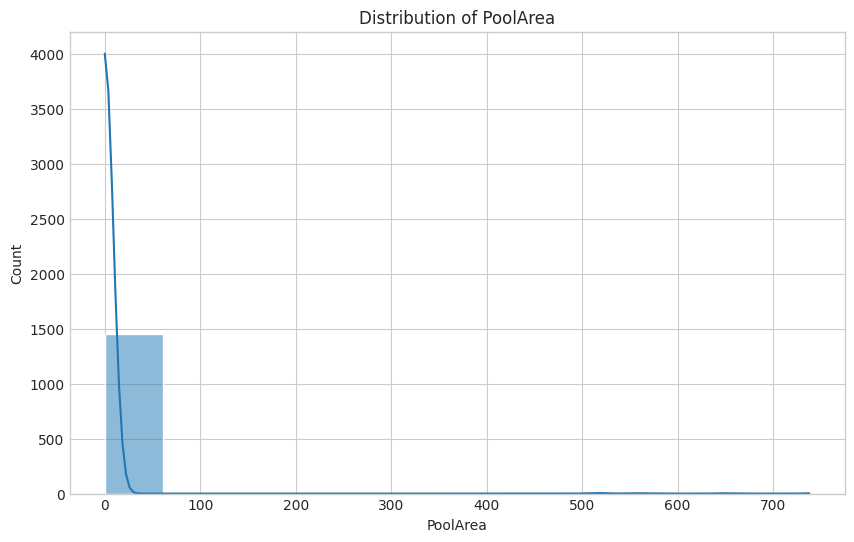


PoolArea value counts:
PoolArea
0      1452
512       1
648       1
576       1
555       1
519       1
738       1
Name: count, dtype: int64

Percentage of homes with no pool: 99.59%

Scaling statistics for PoolArea:
          Original  StandardScaler  MinMaxScaler  RobustScaler
count  1458.000000    1.458000e+03   1458.000000   1458.000000
mean      2.433471    4.873407e-18      0.003297      2.433471
std      38.209947    1.000343e+00      0.051775     38.209947
min       0.000000   -6.370868e-02      0.000000      0.000000
25%       0.000000   -6.370868e-02      0.000000      0.000000
50%       0.000000   -6.370868e-02      0.000000      0.000000
75%       0.000000   -6.370868e-02      0.000000      0.000000
max     738.000000    1.925726e+01      1.000000    738.000000


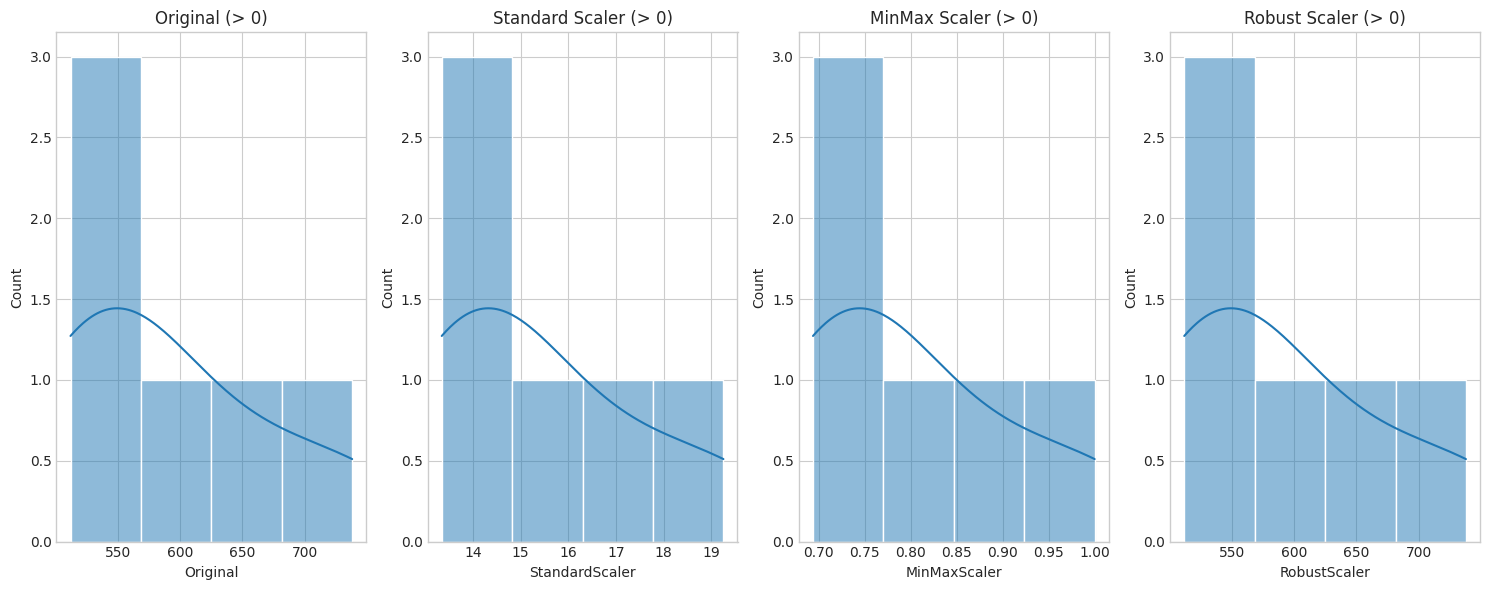



2d. Categorical variables encoding strategy:

Number of unique values in each categorical column:
Neighborhood: 17 unique values
Exterior1st: 8 unique values
Exterior2nd: 8 unique values
HouseStyle: 6 unique values
BsmtFinType1: 6 unique values
LotConfig: 5 unique values
BldgType: 5 unique values
BsmtFinType2: 5 unique values
HeatingQC: 5 unique values
MSZoning: 4 unique values
LotShape: 4 unique values
LandContour: 4 unique values
Condition1: 4 unique values
ExterQual: 4 unique values
Foundation: 4 unique values
BsmtQual: 4 unique values
BsmtCond: 4 unique values
BsmtExposure: 4 unique values
KitchenQual: 4 unique values
Functional: 4 unique values
FireplaceQu: 4 unique values
GarageType: 4 unique values
SaleType: 4 unique values
SaleCondition: 4 unique values
LandSlope: 3 unique values
RoofStyle: 3 unique values
MasVnrType: 3 unique values
ExterCond: 3 unique values
Electrical: 3 unique values
GarageFinish: 3 unique values
GarageQual: 3 unique values
GarageCond: 3 unique values
Pav

In [26]:


# 2c. Special consideration for PoolArea
print("\n\n2c. Analysis of PoolArea for scaling:")

# Check distribution of PoolArea
plt.figure(figsize=(10, 6))
sns.histplot(train_data_no_outliers['PoolArea'], kde=True)
plt.title('Distribution of PoolArea')
plt.savefig('PoolArea_distribution.png')
plt.show()

print(f"\nPoolArea value counts:")
print(train_data_no_outliers['PoolArea'].value_counts())

print(f"\nPercentage of homes with no pool: {(train_data_no_outliers['PoolArea'] == 0).mean() * 100:.2f}%")

# Compare different scaling methods for PoolArea
pool_area = train_data_no_outliers['PoolArea'].values.reshape(-1, 1)

# Standard Scaler
std_scaler = StandardScaler()
pool_std = std_scaler.fit_transform(pool_area)

# MinMax Scaler
minmax_scaler = MinMaxScaler()
pool_minmax = minmax_scaler.fit_transform(pool_area)

# Robust Scaler
robust_scaler = RobustScaler()
pool_robust = robust_scaler.fit_transform(pool_area)

# Create DataFrame for comparison
scaling_df = pd.DataFrame({
    'Original': pool_area.flatten(),
    'StandardScaler': pool_std.flatten(),
    'MinMaxScaler': pool_minmax.flatten(),
    'RobustScaler': pool_robust.flatten()
})

# Show statistics for each scaling method
print("\nScaling statistics for PoolArea:")
print(scaling_df.describe())

# Plot comparison of scaling methods for PoolArea
plt.figure(figsize=(15, 6))
plt.subplot(1, 4, 1)
sns.histplot(scaling_df['Original'][scaling_df['Original'] > 0], kde=True)
plt.title('Original (> 0)')

plt.subplot(1, 4, 2)
sns.histplot(scaling_df['StandardScaler'][scaling_df['Original'] > 0], kde=True)
plt.title('Standard Scaler (> 0)')

plt.subplot(1, 4, 3)
sns.histplot(scaling_df['MinMaxScaler'][scaling_df['Original'] > 0], kde=True)
plt.title('MinMax Scaler (> 0)')

plt.subplot(1, 4, 4)
sns.histplot(scaling_df['RobustScaler'][scaling_df['Original'] > 0], kde=True)
plt.title('Robust Scaler (> 0)')

plt.tight_layout()
plt.savefig('PoolArea_scaling_comparison.png')
plt.show()

# 2d. Categorical variables encoding
print("\n\n2d. Categorical variables encoding strategy:")

# Check the number of unique values in each categorical column
cat_unique_counts = {col: train_data_no_outliers[col].nunique() for col in categorical_cols}
print("\nNumber of unique values in each categorical column:")
for col, count in sorted(cat_unique_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count} unique values")

# Determine which categorical variables have high cardinality
high_cardinality = [col for col, count in cat_unique_counts.items() if count > 10]
print("\nHigh cardinality categorical variables:")
for col in high_cardinality:
    print(f"- {col}")

# Group rare categories to reduce cardinality
def group_rare_categories(df, column, threshold=0.01):
    """Group categories that appear less than threshold% of the time into 'Other'"""
    if column not in df.columns:
        return df

    value_counts = df[column].value_counts(normalize=True)
    # Categories to keep (appear more than threshold% of the time)
    categories_to_keep = value_counts[value_counts >= threshold].index.tolist()

    # Copy the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Replace rare categories with 'Other'
    df_copy[column] = df_copy[column].apply(lambda x: x if x in categories_to_keep else 'Other')

    return df_copy

# Apply grouping for high cardinality columns
for col in high_cardinality:
    if col in train_data_no_outliers.columns:
        train_data_no_outliers = group_rare_categories(train_data_no_outliers, col)
        if col in test_data_filled.columns:
            test_data_filled = group_rare_categories(test_data_filled, col)

# Check the new counts after grouping
new_cat_counts = {col: train_data_no_outliers[col].nunique() for col in high_cardinality
                 if col in train_data_no_outliers.columns}
print("\nNew unique counts after grouping rare categories:")
for col, count in new_cat_counts.items():
    print(f"{col}: {count} unique values")

# Create a preprocessing pipeline for both numeric and categorical variables
numeric_features = [col for col in numeric_cols if col not in no_scaling_needed]
categorical_features = categorical_cols

# Choose a scaler based on our analysis (RobustScaler is good for data with outliers)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
    ])

# Prepare the feature matrix X and target vector y
X = train_data_no_outliers.drop('SalePrice', axis=1)
y = train_data_no_outliers['SalePrice']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Get the feature names after one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

print(f"\nOriginal number of features: {X.shape[1]}")
print(f"Number of features after preprocessing: {X_train_processed.shape[1]}")


In [27]:

# ----------------------------------------------------------------
# 3. Data Modeling
# ----------------------------------------------------------------

# 3a. Choose metric to optimize for regression
print("\n\n3a. Choosing metrics for regression optimization:")

print("""
For this housing price prediction task, we'll use these metrics:
1. R-squared (R²): To understand the proportion of variance explained by the model
2. Mean Absolute Error (MAE): For interpretability of average error in dollars
3. Root Mean Squared Error (RMSE): To penalize large errors more heavily
""")




3a. Choosing metrics for regression optimization:

For this housing price prediction task, we'll use these metrics:
1. R-squared (R²): To understand the proportion of variance explained by the model
2. Mean Absolute Error (MAE): For interpretability of average error in dollars
3. Root Mean Squared Error (RMSE): To penalize large errors more heavily



In [ ]:
# 3b. Implement Statsmodel OLS and drop insignificant variables
print("\n\n3b. Implementing Statsmodel OLS and dropping insignificant variables:")

# Import formula API
import statsmodels.formula.api as smf

# Reset to original data
X_train_clean = X_train.copy()

# Print data types and check for problematic columns
print("Data types in X_train:")
print(X_train.dtypes.value_counts())

# Create a complete dataframe for formula API (including target variable)
model_data = X_train.copy()
model_data['SalePrice'] = y_train

# Make sure column names are valid for formula API
# Replace spaces and special characters with underscores
# Make sure column names are valid for formula API
# Replace spaces and special characters with underscores AND add 'x' prefix to columns that start with numbers
model_data.columns = ['x' + col.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').replace('/', '_').replace(':', '_') if col[0].isdigit() else col.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').replace('/', '_').replace(':', '_') for col in model_data.columns]
# Use formula API to handle categorical variables automatically
# Use Q() to quote problematic variable names in the formula
formula = 'SalePrice ~ ' + ' + '.join([f"Q('{col}')" if not col.isidentifier() else col for col in model_data.columns if col != 'SalePrice'])

try:
    # Fit the model using formula API
    ols_model = smf.ols(formula=formula, data=model_data).fit()
    print(ols_model.summary())
except Exception as e:
    # If that fails, try a stripped-down version with just numeric columns
    print(f"Error with full model: {e}")
    print("Trying with numeric columns only...")

    # Get numeric columns only
    numeric_cols = model_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'SalePrice']

    # Create a simpler formula with just numeric columns
    simple_formula = 'SalePrice ~ ' + ' + '.join(numeric_cols)
    ols_model = smf.ols(formula=simple_formula, data=model_data).fit()
    print(ols_model.summary())

# Function to drop insignificant variables based on p-values
def drop_insignificant_vars_formula(model, data, formula, significance_level=0.05):
    """
    Iteratively drop variables with p-values above the significance level
    Using formula API
    """
    current_model = model
    drop_columns = []

    # Get current p-values
    p_values = current_model.pvalues[1:]  # Skip the intercept

    # Check if any p-values are above threshold
    while p_values.max() > significance_level:
        # Find the variable with the highest p-value
        max_pvalue_var = p_values.idxmax()
        max_pvalue = p_values.max()

        # Don't drop the constant term
        if max_pvalue_var != 'Intercept':
            print(f"Dropping {max_pvalue_var} with p-value {max_pvalue:.4f}")
            drop_columns.append(max_pvalue_var)

            # Remove variable from formula
            variables = formula.split(' ~ ')[1].split(' + ')
            variables = [var for var in variables if var != max_pvalue_var]
            new_formula = formula.split(' ~ ')[0] + ' ~ ' + ' + '.join(variables)

            # Refit model with new formula
            current_model = smf.ols(formula=new_formula, data=data).fit()

            # Update formula for next iteration
            formula = new_formula

            # Update p-values
            p_values = current_model.pvalues[1:]  # Skip the intercept
        else:
            break

    return current_model, drop_columns, formula

# Apply the function to drop insignificant variables
try:
    significant_model, dropped_vars, final_formula = drop_insignificant_vars_formula(
        ols_model, model_data, formula, significance_level=0.05
    )
except Exception as e:
    # If we're using the simpler model with just numeric variables:
    print(f"Error in drop_insignificant_vars: {e}")
    print("Using simpler model with numeric variables only")
    significant_model, dropped_vars, final_formula = drop_insignificant_vars_formula(
        ols_model, model_data, simple_formula, significance_level=0.05
    )

print(f"\nNumber of variables dropped due to insignificance: {len(dropped_vars)}")
print("Variables dropped:")
for var in dropped_vars[:20]:  # Show first 20 if there are many
    print(f"- {var}")
if len(dropped_vars) > 20:
    print(f"... and {len(dropped_vars) - 20} more")

print("\nFinal model summary:")
print(significant_model.summary())

Streaming output truncated to the last 5000 lines.
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrical[T.Other] with p-value 0.9734
Dropping Electrica

In [ ]:
# 3b. Implement Statsmodel OLS and drop insignificant variables
print("\n\n3b. Implementing Statsmodel OLS and dropping insignificant variables:")

# Create a new dataframe with encoded categorical variables for statsmodels
# This is done separately from sklearn pipeline to maintain feature names
X_train_sm = X_train.copy()

# Encode categorical variables and convert all to numeric
for col in X_train_sm.select_dtypes(include=['object', 'category']).columns:
    # Get dummies and convert to numeric
    try:
        X_train_sm[col] = pd.to_numeric(X_train_sm[col])
    except ValueError:
        dummies = pd.get_dummies(X_train_sm[col], prefix=col, drop_first=True, dtype=int)
        X_train_sm = pd.concat([X_train_sm, dummies], axis=1)
        X_train_sm.drop(col, axis=1, inplace=True)

# Add a constant to the model
X_train_sm = sm.add_constant(X_train_sm)

# Fit the OLS model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Display the summary
print(ols_model.summary())
# ... (rest of the code remains the same)

In [ ]:


# 3c. VIF analysis for multicollinearity
print("\n\n3c. VIF analysis for multicollinearity:")

# Calculate VIF for each feature in the significant model
X_for_vif = X_train_significant.drop('const', axis=1)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

# Sort by VIF value
vif_data = vif_data.sort_values('VIF', ascending=False)
print("VIF values for features:")
print(vif_data)

# Identify high VIF variables (common threshold is 5 or 10)
high_vif_threshold = 10
high_vif_vars = vif_data[vif_data["VIF"] > high_vif_threshold]["Feature"].tolist()

print(f"\nFeatures with high VIF (> {high_vif_threshold}):")
for var in high_vif_vars:
    print(f"- {var} (VIF: {vif_data[vif_data['Feature'] == var]['VIF'].values[0]:.2f})")

# Function to iteratively remove features with high VIF
def remove_high_vif_features(X, threshold=10):
    X_copy = X.copy()
    max_vif = float('inf')

    # Iteratively remove features with high VIF
    while max_vif > threshold:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_copy.columns
        vif_data["VIF"] = [variance_inflation_factor(X_copy.values, i) for i in range(X_copy.shape[1])]

        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            # Remove the feature with the highest VIF
            max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
            X_copy = X_copy.drop(max_vif_feature, axis=1)
            print(f"Dropped {max_vif_feature} with VIF: {max_vif:.2f}")

    return X_copy

# Remove high VIF features
X_low_vif = remove_high_vif_features(X_for_vif, threshold=10)

print(f"\nFeatures remaining after removing high VIF: {X_low_vif.shape[1]}")

# Refit the model with low VIF features
X_low_vif_with_const = sm.add_constant(X_low_vif)
final_ols_model = sm.OLS(y_train, X_low_vif_with_const).fit()

print("\nFinal model summary after removing high VIF features:")
print(final_ols_model.summary())

# 3d. Residual analysis
print("\n\n3d. Residual analysis:")

# Get the predictions and residuals
y_train_pred = final_ols_model.predict(X_low_vif_with_const)
residuals = y_train - y_train_pred

# Create residual plots
plt.figure(figsize=(20, 12))

# 1. Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

# 2. Q-Q plot
plt.subplot(2, 2, 2)
sm.graphics.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot')

# 3. Scale-Location plot
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_train_pred, y=np.sqrt(np.abs(residuals)))
plt.xlabel('Fitted values')
plt.ylabel('√|Residuals|')
plt.title('Scale-Location Plot')

# 4. Histogram of residuals
plt.subplot(2, 2, 4)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')

plt.tight_layout()
plt.savefig('residual_analysis.png')
plt.show()

# Test for normality of residuals
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test for normality: p-value = {shapiro_test[1]:.6f}")

# Apply log transformation to address non-normality if needed
log_y = np.log1p(y_train)  # log(1+y) to handle potential zeros
log_model = sm.OLS(log_y, X_low_vif_with_const).fit()

# Get predictions and residuals after log transformation
log_y_pred = log_model.predict(X_low_vif_with_const)
log_residuals = log_y - log_y_pred

# Test normality after transformation
shapiro_test_log = stats.shapiro(log_residuals)
print(f"Shapiro-Wilk test after log transformation: p-value = {shapiro_test_log[1]:.6f}")

# Plot residuals after transformation
plt.figure(figsize=(20, 12))

# 1. Residuals vs Fitted (log)
plt.subplot(2, 2, 1)
sns.scatterplot(x=log_y_pred, y=log_residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values (log)')
plt.ylabel('Residuals (log)')
plt.title('Residuals vs Fitted (log transform)')

# 2. Q-Q plot (log)
plt.subplot(2, 2, 2)
sm.graphics.qqplot(log_residuals, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot (log transform)')

# 3. Scale-Location plot (log)
plt.subplot(2, 2, 3)
sns.scatterplot(x=log_y_pred, y=np.sqrt(np.abs(log_residuals)))
plt.xlabel('Fitted values (log)')
plt.ylabel('√|Residuals| (log)')
plt.title('Scale-Location Plot (log transform)')

# 4. Histogram of residuals (log)
plt.subplot(2, 2, 4)
sns.histplot(log_residuals, kde=True)
plt.xlabel('Residuals (log)')
plt.title('Histogram of Residuals (log transform)')

plt.tight_layout()
plt.savefig('log_residual_analysis.png')
plt.show()

# Compare model performance before and after log transformation
# Convert log predictions back to original scale
y_pred_original_scale = np.expm1(log_y_pred)

# Calculate metrics for both models
r2_original = r2_score(y_train, y_train_pred)
mae_original = mean_absolute_error(y_train, y_train_pred)
rmse_original = np.sqrt(mean_squared_error(y_train, y_train_pred))

r2_log = r2_score(y_train, y_pred_original_scale)
mae_log = mean_absolute_error(y_train, y_pred_original_scale)
rmse_log = np.sqrt(mean_squared_error(y_train, y_pred_original_scale))

print("\nModel performance comparison:")
print(f"Original model - R²: {r2_original:.4f}, MAE: ${mae_original:.2f}, RMSE: ${rmse_original:.2f}")
print(f"Log-transformed model - R²: {r2_log:.4f}, MAE: ${mae_log:.2f}, RMSE: ${rmse_log:.2f}")

# 3e. Gradient-based regressor
print("\n\n3e. Implementing gradient-based regressor:")
